**<center><font size=5>SETI Breakthrough Listen - E.T. Signal Search 👽</font></center>**
<center><font size=4>By Ben Shaver and Coral Hayoun</font></center>

----
# Abstract

##### **"Are we alone in the Universe?"**

It's one of the most profound human questions.
As technology improves, we're finding new and more powerful ways to seek for answers.

The Breakthrough Listen team at Berkeley University, scans signals from millions of stars in the universe using world's most powerful telescopes, trying
to answer this question. Unfortunately, finding extraterrestial signals is not that easy - by the time, humans have built enormous numbers of radio devices that can be detected as signals as well and distract researchers.

In order to separate outer space signals from RFI (radio frequency interference), The Breakthrough Listen team are using two different filters:
1. They intersperses scans of target stars that apprears in more than one regions of the sky - because these scans probably aren't coming from the direction of the target star.
2. They discards signals that don't change their frequency - because it means that they are probably nearby the telescope.

These two methods are quite effective, but they can be improved. The process today misses interesting signals. particularly those with complex time or frequency structure, and those in regions of the spectrum with lots of interference.

<br></br>
In this competition, we will use our machine learning skills to accurately identify the presence of simulated extraterrestial signals in these scans.

Because there are no confirmed examples of alien signals to use to train machine learning algorithms, the team included some simulated signals (that they call “**needles**”) in the haystack of data from the telescopes. They have identified some of the hidden needles so that we can train our model to find more.

<br></br>
<center><img src="https://i.pinimg.com/originals/89/e6/91/89e6912b1225c43ed18b7c2b31069f77.jpg" width="600"></center>

(from [SETI Breakthrough Listen - Kaggle competition](https://www.kaggle.com/competitions/seti-breakthrough-listen)) <br></br>

----

##### **Table of Contents**
- <a href='#1'>1. Initial Settings | ⚙️</a>
- <a href='#2'>2. Exploratory Data Analysis | 🔦</a>
  - <a href='#2_1'>2.1. Data Loading</a>
  - <a href='#2_2'>2.2. Data Visualizing</a>
  - <a href='#2_3'>2.3. Data Statistics</a>
- <a href='#3'>3. Data Preprocessing | 🍽️</a>
  - <a href='#3_1'>3.1. Data Cleaning</a>
  - <a href='#3_2'>3.2. Data Augmentation</a>
  - <a href='#3_3'>2.3. Data Adjustments</a>
- <a href='#4'>4. Data Splitting | 🔪</a>
- <a href='#5'>5. Train A Simple Model | 🐇</a>
  - <a href='#5_1'>5.1. Model Building</a>
  - <a href='#5_2'>5.2. Preprocessing Pipeline</a>
  - <a href='#5_3'>5.3. Training Function</a>
  - <a href='#5_4'>5.4. Predictions</a>
  - <a href='#5_5'>5.5. Final Results</a>
- <a href='#6'>6. Train An Improved Simple Model | 🦍</a>
- <a href='#7'>7. Train A Deep Learning Model | 🤖</a>
  - <a href='#7_1'>7.1. Model Building</a>
  - <a href='#7_2'>7.2. Preprocessing Pipeline</a>
  - <a href='#7_3'>7.3. Training Function</a>
  - <a href='#7_4'>7.4. Predictions</a>
  - <a href='#7_5'>7.5. Final Results</a>


  ----

# <a id='1'>1. Initial Settings | ⚙️</a>

##### 1. Install Libraries

In [ ]:
%pip install setigen

##### 2. Import Libraries

In [22]:
# For operating system and file system
import os
import time
import logging

# For basic functionallity
import math

# For data manipulation and analysis
import numpy as np
import pandas as pd

# For Computer Vision Library
import cv2
from skimage.transform import resize

# For Deep Learning
import tensorflow as tf
import efficientnet.tfkeras as efficientnet
from tensorflow.keras import layers
from tqdm.keras import TqdmCallback

# For Machine Learning
import sklearn
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import SGDClassifier
from sklearn.decomposition import PCA

# For data manipulation
from skimage.transform import resize
from astropy import units as u
import setigen as stg

# For data visualization
import matplotlib.pyplot as plt

# For model persistence
import joblib

# For warning filtering
import warnings

In [16]:
# Sometimes it can be necessary to re-run this command for plots to show automatically
%matplotlib inline

##### 3. Libraries Version

In [ ]:
print('np version:',np.__version__)
print('pd version:',pd.__version__)
print('tf version:',tf.__version__)
print('sklearn version:',sklearn.__version__)

np version: 1.26.4
pd version: 2.1.4
tf version: 2.16.1
sklearn version: 1.2.2


##### 4. Configuration

In [12]:
class CFG:
    # ------------------------------------#
    # Basic
    # ------------------------------------#
    debug = True
    runOnKaggle = False
    epochs = 1
    train_batch_size = 64
    validation_batch_size = 20
    data_augmentation_size = 5000
    test_batch_size = 64
    seed = 42
    k_fold = 4

    # ------------------------------------#
    # Paths
    # ------------------------------------#
    base_folder_path = os.path.abspath('../../../Downloads/SETI')
    train_folder_path = f'{base_folder_path}/train'
    test_folder_path = f'{base_folder_path}/test'
    workdir_folder_path = 'working'
    tmp_storage_path = 'tmp'
    logging_file = 'logging.txt'

# ------------------------------------#
# Utils
# ------------------------------------#
def get_data_set_sample(data_set, n, positive_ratio):
    positive_values_samples = min(math.floor(n * positive_ratio),len(data_set[data_set.target == 1]))
    positive_samples = data_set[data_set.target == 1].sample(n=positive_values_samples, random_state = CFG.seed).reset_index(drop=True)
    complementary_data_set_samples = data_set[data_set.target == 0].sample(n - positive_values_samples, random_state = CFG.seed).reset_index(drop=True)

    return pd.concat([positive_samples, complementary_data_set_samples]).sample(frac = 1).reset_index(drop=True)

# ------------------------------------#
# Datasets
# ------------------------------------#
training_set = pd.read_csv(f'{CFG.base_folder_path}/train_labels.csv')
testing_set = pd.read_csv(f'{CFG.base_folder_path}/sample_submission.csv')
# Fixed testing set target to be binary (in the submissions file its value is 0.5)
testing_set['target'] = 0

# ------------------------------------#
# On Debug
# ------------------------------------#
if CFG.debug:
    CFG.epochs = 1
    CFG.train_batch_size = 50
    CFG.validation_batch_size = 25
    CFG.test_batch_size = 50
    CFG.data_augmentation_size = 500
    
    CFG.test_folder_path = CFG.train_folder_path
    training_set = get_data_set_sample(training_set, 2000, 0.3)
    testing_set = get_data_set_sample(training_set, 2000, 0.3)

    training_set.to_csv('train_debug.csv', index=False)
    testing_set.to_csv('test_debug.csv', index=False)

# ------------------------------------#
# On Kaggle Running
# ------------------------------------#
if CFG.runOnKaggle:
    CFG.tmp_storage_path = '/kaggle/tmp'

##### 5. Utils Methods

In [98]:
def get_batched_data (data, batch_size, index):
  return data[index * batch_size : (index + 1) * batch_size]

def split_data(data, k):
    np.random.shuffle(data)
    return np.array_split(data, k)

def plot_cadence_snippet(cadence_snippet):
  figure = plt.figure(figsize=(8, 5))
  
  for i in range(6):
    plt.subplot(6, 1, i + 1)
    plt.imshow(cadence_snippet[i].astype('float16'), aspect='auto')

  figure.text(0.5, 0.04, 'Frequency', ha='center', fontsize=8)
  figure.text(0.04, 0.5, 'Time', va='center', rotation='vertical', fontsize=8)
  plt.show()

def plot_on_channels_cadence_snippet(cadence_snippet):
  figure = plt.figure(figsize=(8, 4))
  
  for i in range(3):
    plt.subplot(6, 1, i + 1)
    plt.imshow(cadence_snippet[i], aspect='auto')

  figure.text(0.5, 0.04, 'Frequency', ha='center', fontsize=8)
  figure.text(0.04, 0.5, 'Time', va='center', rotation='vertical', fontsize=8)
  plt.show()

def plot_merged_cadence_snippet(file, title = None):
  plt.figure(figsize=(8, 5))

  if title is not None: 
    plt.title(title) 
    
  plt.imshow(file, aspect='auto')

def write_predictions_to_file(prediction_data, testing_set_labels, file_name):
  results = testing_set_labels.assign(target=prediction_data)
  selected_column = ['id', 'target']
  final_results = results[selected_column]
  final_results.to_csv(file_name, index=False)

def get_batch_number(index, batch_size):
  return math.floor(index / batch_size)

def get_index_in_batch(index, batch_size):
  return index - (get_batch_number(index, batch_size) * batch_size)

def log(message, shouldPrint=False):
  if shouldPrint:
    print(message)
  logging.info(message)

def save_model(model, name):
  joblib.dump(model, f'{CFG.workdir_folder_path}/{name}.pkl')
  
def load_model(name):
  return joblib.load(f'{CFG.workdir_folder_path}/{name}.pkl')

def get_duration(start_time):
  return (time.time() - start_time) / 60

##### 6. Initial Methods

In [79]:
# Create tmp Directory
if not os.path.exists(CFG.tmp_storage_path):
    os.makedirs(CFG.tmp_storage_path)

# Create working Directory
if not os.path.exists(CFG.workdir_folder_path):
    os.makedirs(CFG.workdir_folder_path)
    
# Create logging file
if not os.path.exists(CFG.logging_file):
    with open(CFG.logging_file, 'w'):
        pass

# Setup logger
logging.basicConfig(
    level=logging.INFO,  
    format='%(asctime)s - %(message)s',  
    filename=CFG.logging_file,  
    filemode='a'  
  )

# Remove unnecessary warnings
warnings.filterwarnings('ignore', r'overflow encountered in reduce')
warnings.filterwarnings('ignore', r'Applying `local_binary_pattern`')

----

# <a id='2'>2. Exploratory Data Analysis | 🔦</a>


With our libraries and configurations set up, we can begin the exploratory data analysis (or EDA).

The **goal of EDA** is to understand the data underlying structure and patterns, identify important variables, detect outliers and anomalies and formulate hypotheses for further investigation. 

This process will involve several steps including data loading, visualizations and some data statistics.


### <a id='2_1'>2.1. Data Loading</a>

Even though our task sounds like a *signal* detection problem, we have decided to be solving it as *image* classification problem.

The data we are provided with is radio spectrograms - a visual representation of the spectrum frequencies of a signal as it varies with time. <br></br>


Our dataset actually contains:
- a `train_labels.csv` file, which has our labels indicating the presence of an alien signal (referred to as needles) for each of the spectograms
- `train` folder contains `.npy` float16 files with the spectrograms stored as arrays
- Similarly, `test` folder also contains `.npy` float16 files with the test spectrograms stored as arrays
- Of course, we are provided with a `test_labels.csv` file! <br></br>

Now, let's check our `train` data:

In [13]:
def get_file_path(image_id, folder_path):
  return '{}/{}/{}.npy'.format(folder_path, image_id[0], image_id)

training_set['file_path'] = training_set['id'].apply(lambda id: get_file_path(image_id=id, folder_path=CFG.train_folder_path))
testing_set['file_path'] = testing_set['id'].apply(lambda id: get_file_path(image_id=id, folder_path=CFG.test_folder_path))

# Create test_labels.csv
testing_files = testing_set['file_path']
testing_set.assign(file=testing_files).to_csv('test_labels.csv', index=False)
testing_set_labels = pd.read_csv('test_labels.csv')
testing_set_labels['predicted_label'] = 0

training_set.head()

,id,target,file_path
0,c897b40267e0419,0,c:\Users\koral\Downloads\SETI/train/c/c897b402...
1,1272fecd744a31b,0,c:\Users\koral\Downloads\SETI/train/1/1272fecd...
2,6c770f493a57d8f,0,c:\Users\koral\Downloads\SETI/train/6/6c770f49...
3,5ef886a95903258,0,c:\Users\koral\Downloads\SETI/train/5/5ef886a9...
4,6f2edd217069c60,0,c:\Users\koral\Downloads\SETI/train/6/6f2edd21...


### <a id='2_2'>2.2. Data Visualizing</a>

Every training set example is called **cadence snippet**, which looks like this:

My shape is: (6, 273, 256)


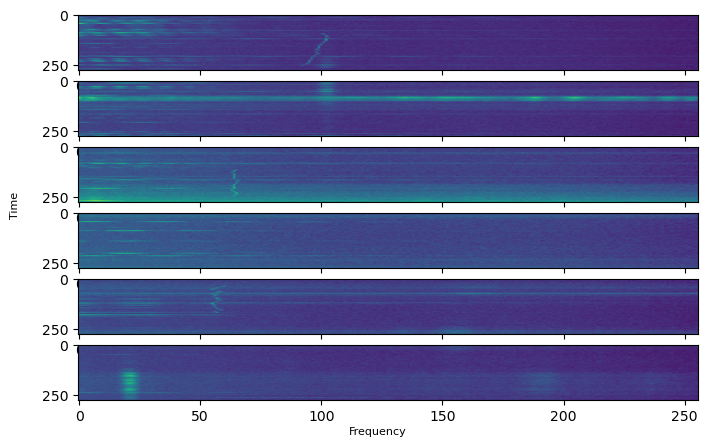

In [14]:
cadence_snippet = np.load(get_file_path('00776881dd80050', CFG.train_folder_path))
print(f'My shape is: {cadence_snippet.shape}')
plot_cadence_snippet(cadence_snippet)

Now, let's break this **cadence snippet** down:

**Firstly**, the individual plots signify a **cadence**, and the combination of the 6 plots is called a **cadence snippet**

**Secondly**, as we can see, the spectrogram has a shape of `(6, 273, 256)` - which stands for a represantation of 6 spectrograms in 2D.
The reason for the 6 spectrograms, as we already mentioned in the Abstract section, is that in order to deal with human-generated signals (like radion stations or wifi routers), Breakthrough Listen team are looking for **signals that appear to be coming from particular positions on the sky**.

Typically they do this by alternating observations of a primary target star with observations of three nearby stars:
- 5 minutes on star “A”
- then 5 minutes on star “B”
- then back to star “A” for 5 minutes
- then “C”
- then back to “A”
- then finishing with 5 minutes on star “D”.

One set of six observations (ABACAD) is referred to as our **cadence snippet**.

**Thirdly**, The curves we see in the signal's lines, are because the relative motion of the Earth and the star imparts a `Doppler drift`, causing the frequency to change over time. 


<br></br>Now, let's watch some more cadence snippets:

Here is a non-alien signals example:


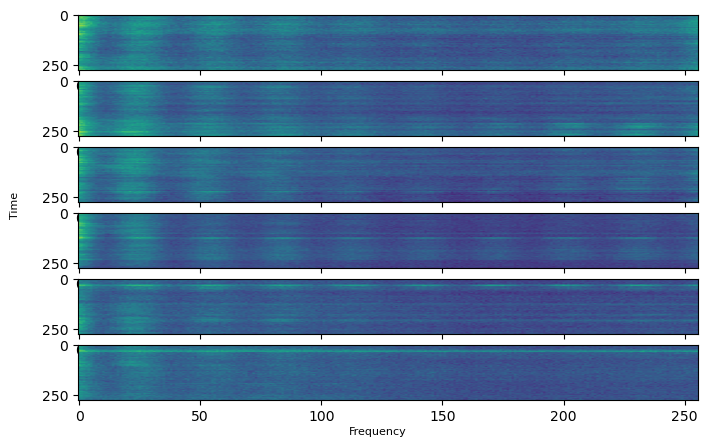


Here is an easy alien signals example:


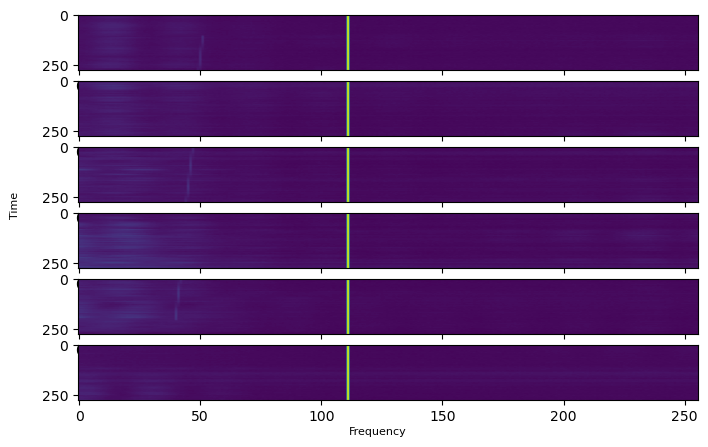


Here is a hard alien signals example:


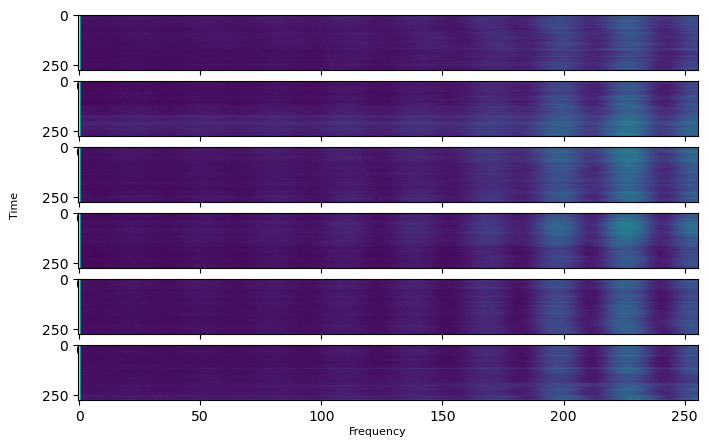

In [37]:
print('Here is a non-alien signals example:')
plot_cadence_snippet(np.load(get_file_path('0000799a2b2c42d', CFG.train_folder_path)))

print('\nHere is an easy alien signals example:')
plot_cadence_snippet(np.load(get_file_path('d618b77bb0909c2', CFG.train_folder_path)))

print('\nHere is a hard alien signals example:')
plot_cadence_snippet(np.load(get_file_path('fffbb1c9c3d6c31', CFG.train_folder_path)))

Right now, we came across with our **1st problem: hidden needles**

As we can see, some of these needles should be easy to detect, but others are hidden in noisy regions of the spectrum and will be harder. <br></br>


### <a id='2_3'>2.3. Data Statistics</a>

Let's create a histogram of the label frequencies in order to understand how rare is having a "needle" occurance:

There are 6000 'needles', which is 10.0 % of the training set. 



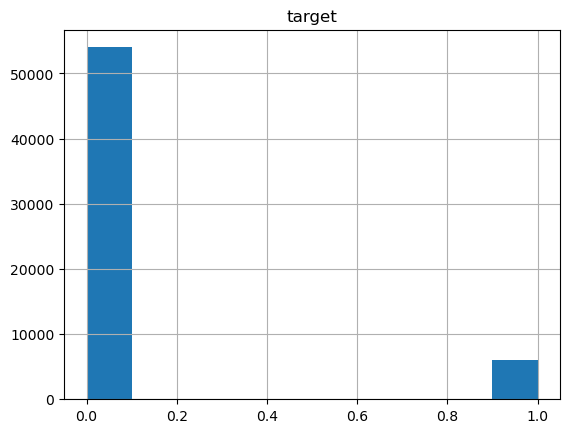

In [ ]:
training_set.hist()

needles = len(training_set[training_set.target==1])

print(f"There are {needles} 'needles', which is {(needles / len(training_set) * 100)} % of the training set. \n")

By looking at this histogram, we can see that our **2nd problem** is a very imbalanced dataset - most of the examples are non-alien. If we will use this dataset for our predictive models without any adjustments, we might get a lot of misclassifications.

> **Imbalance** means that the number of data points available for different the classes is different
<br></br>

----

# <a id='3'>3. Data Preprocessing | 🍽️</a>

There are few things we can do to make the data more effiecient for our needs:

1. **Data Cleaning** - we can remove noises from the data and keep only the relevant features of the data.
2. **Data Augmentation** - we can apply data augmentation techniques to increase the diversity of the training dataset, like - rotation, flipping, scaling, or adding noise to the spectrograms.
3. **Data Adjustments** - we can make some adjustemnts to our image like resizing, normalizing the pixels values, etc.


### <a id='3_1'>3.1. Data Cleaning</a>

As we can see in the Data Visualizing section - the horizontal lines of the spectrograms are mostly noise and can be eliminated (the vertical or inclined lines are the ones that relevant for us). This can help us overcome the **1st problem: hidden needles** from the EDA section.

For filtering out horizontal lines, we can use `Fourier Transform`, but first - we need to understand its meaning


>In the picture below, we can see the **Time Domain** representation of a audio signal, which shows the "loudness" (amplitude) of sounds wave changing with time. To better understand a audio signal, it is necessary to transform it into the **Frequency Domain** representation. This representation of a signal tells us what different frequencies are present in the signal.<br></br>
  <img src="https://miro.medium.com/v2/resize:fit:720/format:webp/1*e-_z80BnbHWyFTfRLblJ_w.gif" width="400"> <br></br>
> **Fourier Transform** is a mathematical concept that can *decompose a signal into its constituent frequencies*. In its 2D plot output, the x-axis represent the signal frequencies and the y-axis represent their magnitudes (amplitude size). There is also **Inverse Fourier Transform** concept, which is just the opposite of the Fourier Transform.<br></br>
 For a better understanding of Fourier Transform output - let's create two simple sine waves, with two different frequencies:  *amplitude = 1 and frequency = 3* and *amplitude = 2 and frequency = 11*.
 Now, we can combine them into a single signal, that will look like that - <br></br>
  <img src="https://miro.medium.com/v2/resize:fit:720/format:webp/1*WBldOpArJgDXIFs5g_JydA.png" width="400"> <br></br>
> The output of Fourier Transform will show two spikes  for the two frequencies and their magnitues <br></br>
  <img src="https://miro.medium.com/v2/resize:fit:720/format:webp/1*aIyR6XoUYGJp0_3Ug6iEyA.png" width="400"> <br></br>
For more information, you can read the article - [understand autio fft](https://towardsdatascience.com/understanding-audio-data-fourier-transform-fft-spectrogram-and-speech-recognition-a4072d228520)


<br></br>
Having said that, we can use *Fourier Transform* to mask the spectrogram's horizontal lines - 
- We will start by appling `fft algorithem` over our spectrogram.
- We can shift the zero-frequency to the center of the image so our horizontal lines will be represented as vertical lines in the central area of the fourier image.
- We can now mask the central area of the image
- In the end, we will apply the `inverse fft algorithem` (ifft), to return the image to its original format

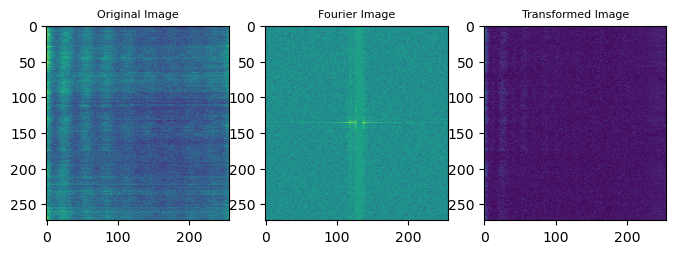

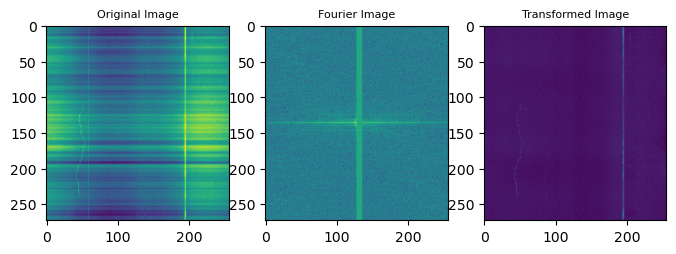

In [34]:
def fourier_vertical_lines_mask(spectrogram):
    spectrogram_frequencies_domain = np.fft.fft2(spectrogram)
    # Shitf the zero-frequency to the center of the image, making it more intuitively
    spectrogram_frequencies_domain = np.fft.fftshift(spectrogram_frequencies_domain)
    # Mask the central area of the fourier image (probably a horizontal line)
    spectrogram_frequencies_domain[:, 128:136] = 1

    return spectrogram_frequencies_domain

def plot_fourier_transform_preprocess(spectrogram, frequencies_domain):
    _ , columns = plt.subplots(1,3,figsize=(8,8))

    # Original Image
    columns[0].imshow(spectrogram)
    columns[0].set_title('Original Image', fontsize = 8)
    # Fourier Transformation Image
    columns[1].imshow(np.log(abs(frequencies_domain)))
    columns[1].set_title('Fourier Image', fontsize = 8)
    # Transformed Image using Inverse Fourier Transformation
    columns[2].imshow(abs(np.fft.ifft2(frequencies_domain)))
    columns[2].set_title('Transformed Image', fontsize = 8)

# Main
spectrograms = [((np.load(f'{CFG.base_folder_path}/example.npy').astype('float16'))/255)[0], 
                ((np.load(f'{CFG.base_folder_path}/positive.npy').astype('float16'))/255)[0]
]

for spectrogram in spectrograms:
  frequencies_domain = fourier_vertical_lines_mask(spectrogram)
  plot_fourier_transform_preprocess(spectrogram, frequencies_domain)

After undestanding the Fourier masking concept, we can write the full preprocess function for our future preprocess pipeline:

In [19]:
def fourier_transform_preprocess(spectrograms):
  masked_spectrograms = []
  for spectrogram in spectrograms:
    spectrogram = spectrogram.astype('float16')/255
    masked_spectrogram = fourier_vertical_lines_mask(spectrogram)
    masked_spectrogram = np.abs(np.fft.ifft2(masked_spectrogram))
    # Float16 type casting is important here! np.abs return its answer in float64 format, which makes our training data 4 times bigger
    masked_spectrograms.append(masked_spectrogram.astype(np.float16))

  return masked_spectrograms

<div style="border: 2px solid; padding: 10px; background-color: #FFFACD; border-radius: 5px; color: #000; font-size:14px; line-height: 1.7em; display: flex; flex-direction: row;">
  <div style="width: 24px">📌</div> <div>While we first ran this function over the entire training set, we payed attention that our processed dataset files are 4 times bigger, which made the whole running process to become much more slower. After some digging and debugging, we understood that np.abs return the results in float64 format instead of float16 (the original image's format) - so, we added float16 casting in the 8 line in order to fix it </div>
</div>

### <a id='3_2'>3.2. Data Augmentation </a>

As we've been discussed before, our **2nd problem** is an imbalanced training set (specifically, the amount of positive examaples is very limited compering to the negative ones). Therefore, we decided to use data augmentation.

Data augmentation could be implemented in multiple ways, either by taking some example from our data and applying to it transformations (like rotation, translation, etc) or by generating new data.
Generating new data is a bit more trickier, so we chose to apply transformations over our positive training set.

After some digging we have encountered a library named `setigen` which can help us with the data augementation as it can generate by itself filterbank's that demoonstrate real one, and there are abilities of adding noise or signals of different forms.

For further information - [seigen github](https://github.com/bbrzycki/setigen/blob/main/README.md) or [seigen doc](https://setigen.readthedocs.io/en/main/index.html)

In [85]:
def get_training_example():
    sample_filepath = training_set[training_set.target == 1].sample(n = 1).reset_index(drop=True).iloc[0]['file_path']
    return np.load(sample_filepath).astype('float16')

def add_noise(cadence):
    signal_starting_frequency = np.random.randint(0, cadence[0].fchans)
    signal_intensity_level = np.random.randint(1, 10)
    signal_width = np.random.randint(1, 10)

    cadence.add_signal(
        stg.constant_path(f_start=cadence[0].fs[signal_starting_frequency], drift_rate=0*u.Hz/u.s),
        stg.constant_t_profile(level=signal_intensity_level),
        stg.box_f_profile(width=signal_width*u.Hz),
        stg.constant_bp_profile(level=1)
    )

    return cadence

def convert_cadence_to_npy_array(cadence):
    cadence_as_numpy_array = []

    for frame in cadence:
        cadence_as_numpy_array.append(frame.get_data())
    
    return np.array(cadence_as_numpy_array)

def create_base_cadence():
    cadence = stg.Cadence()
    sample = get_training_example()

    # Create 6 instances of Frame to construct a Cadence
    for i in range(6):
        frame = stg.Frame(data=sample[i])
        cadence.append(frame)
    
    return cadence

def create_noisy_cadence():
    cadence_snippet = create_base_cadence()
    noisy_cadence_snippet = add_noise(cadence_snippet)

    return convert_cadence_to_npy_array(noisy_cadence_snippet)

We can check out our result by plotting an example of a cadence snippen created from the data augmentation process: 

Before adding noises:
Mean: 4e-06


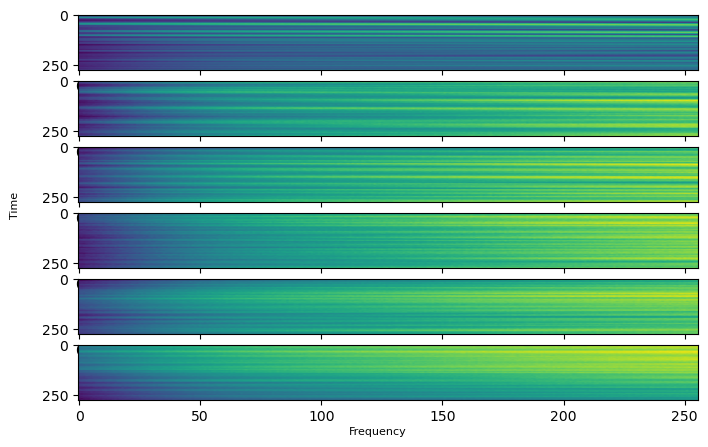

After adding noises:
Mean: 0.03516


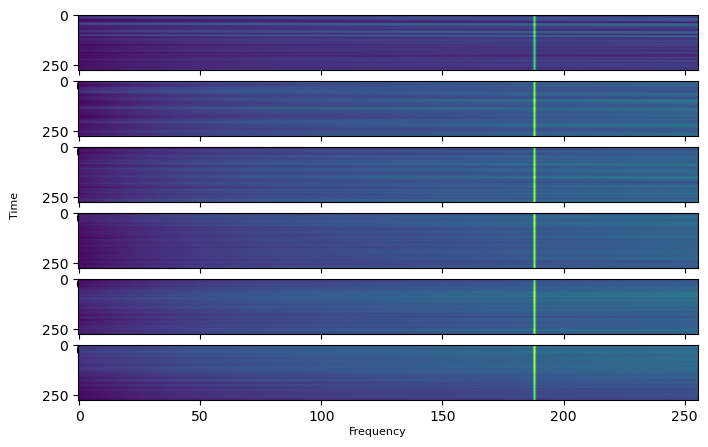

In [86]:
cadence_snippet = create_base_cadence()
cadence_snippet_npy = convert_cadence_to_npy_array(cadence_snippet)

print('Before adding noises:')
print('Mean:', np.mean(cadence_snippet_npy[0]))
plot_cadence_snippet(cadence_snippet_npy)

noisy_cadence_snippet = add_noise(cadence_snippet)
noisy_cadence_snippet_npy = convert_cadence_to_npy_array(noisy_cadence_snippet)

print('After adding noises:')
print('Mean:', np.mean(noisy_cadence_snippet_npy[0]))
plot_cadence_snippet(noisy_cadence_snippet_npy)


The data augmentation should be integrated as simply as possible, so we made it part of the given training set - the files will be saved as npy array files and there will be a `csv` file for the data labels, just like `train_labels.csv`

In [89]:
def data_augmentation(samples_number):
    data_augmentation_data_frame = pd.DataFrame(columns=['id', 'target', 'file_path'])
    
    for i in range(samples_number):
        file_path = f'{CFG.tmp_storage_path}/{i}.npy'
        sample = create_noisy_cadence()
        np.save(file_path, np.asarray(sample, dtype=np.float16))
        data_augmentation_data_frame.loc[i] = [i, 1, file_path]
        
    return data_augmentation_data_frame

In [ ]:
data_augmentation_csv = data_augmentation(CFG.data_augmentation_size)
data_augmentation_csv.to_csv('data_aug_debug.csv', index=False)

Now, we can concat both the original training set with the new data from the data augmentation pre-process.

In [ ]:
training_set = pd.concat([data_augmentation_csv, training_set]).sample(frac = 1).reset_index(drop=True)

### <a id='3_3'>3.3. Data Adjustments </a>

Our training set examples contains `.npy array` of 6 spectrograms, before we can train the model with them - it will be better to merge them into one image and normalize it:

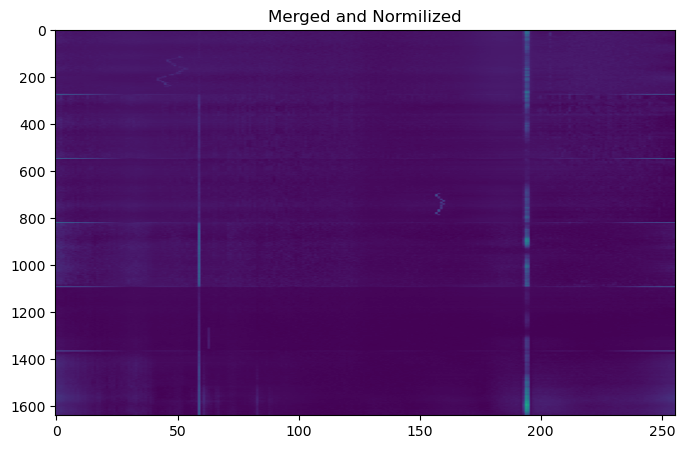

In [20]:
def merge_spectrograms_preprocess(npy_file):
    return np.vstack(npy_file)

def normalize_spectrograms_preprocess(npy_file):
    mean_value = np.mean(npy_file)
    std_value = np.std(npy_file)
    return (npy_file - mean_value) / std_value
    
# Main
example_file = np.load(f'{CFG.base_folder_path}/positive.npy')

example_file = fourier_transform_preprocess((example_file))
example_file = merge_spectrograms_preprocess(example_file)
example_file = normalize_spectrograms_preprocess(example_file)

plot_merged_cadence_snippet(example_file, 'Merged and Normilized')

We've done writing our basic pre-processing functions! In the next sections, we will use them to build our pre-processing pipeline and we will even improve it.
<br></br>

----

# <a id='4'>4. Data Splitting | 🔪</a>

In `K-fold cross-validation`, the original dataset is divided into K subsets (folds) of approximately equal size.
Our model will train K times, each time using K-1 folds as the training data and the remaining fold as the validation data.

This technique helps to provide a more reliable estimate of the model's performance compared to a single train-test split, as it uses multiple validation sets and reduces the variance in the performance estimate.

Now, lets do it:

In [69]:
k_fold_splitter = StratifiedKFold(n_splits=CFG.k_fold, shuffle=True, random_state=CFG.seed)
splitted_training_set = k_fold_splitter.split(training_set, training_set['target'])

for fold_index, (train_index, validation_index) in enumerate(splitted_training_set):
    training_set.loc[validation_index, 'fold'] = int(fold_index)
    training_set['fold'] = training_set['fold'].fillna(-1).astype(int)
    
display(training_set.groupby(['fold', 'target']).size())

fold  target
0     0         350
      1         150
1     0         350
      1         150
2     0         350
      1         150
3     0         350
      1         150
dtype: int64

----

# <a id='5'>5. Train A Simple Model | 🐇</a>

### <a id='5_1'>5.1 Model Building</a>

We have decided to start with a simple machine learning model - `Logistic Regression`, to understand its accuracy.

Logistic Regression is a supervised learning algorithm for a binary classfication task. In this model, the relationship between the input features and the probability of the binary outcome is modeled using the logistic function the sigmoid function. 

<img src="https://helloacm.com/wp-content/uploads/2016/03/logistic-regression-example.jpg" width="300">
<br></br>


We will use the `sklearn.linear_model.SGDClassifier` class as it allows on-line learning with the `partial_fit` method.

In [70]:
model = SGDClassifier(loss='log_loss')

### <a id='5_2'>5.2 Preprocessing Pipeline</a>

After creating all of the preprocessing functions in the third section, we can now create our official preprocessing pipeline:

In [ ]:
def preprocessing_pipeline(data_set):
  processed_data_set = []

  for data_file_path in data_set['file_path']:
    data = (np.load(data_file_path))

    # Mask horizontal lines
    processed_data = fourier_transform_preprocess(data)

    # Merge all spectrograms into one image
    processed_data = merge_spectrograms_preprocess(processed_data)

    # Normalized the spectrograms values
    processed_data = normalize_spectrograms_preprocess(processed_data)
    
    processed_data_set.append(processed_data.flatten())

  return processed_data_set

<div style="border: 2px solid; padding: 10px; background-color: #FFFACD; border-radius: 5px; color: #000; font-size:14px; line-height: 1.7em; display: flex; flex-direction: row;">
  <div style="width: 24px">📌</div> <div> When we first tried to run this pipeline - we did it on the entire training set and saved it results in our memory, which caused our application to crash.
  Then, we understood that we used a very unefficient way for preprocessing the data, so we fixed it:
  <ul>
<li>Firstly, we needed to store the processed data in a place that is not our RAM - so, we chose to do it in our file system</li>
<li>Secondly, we decided to run this process in batching with time.sleep between them</li>
  </ul>
  </div>
</div>


Let's see the code atfer our few teaks:

In [ ]:
def preprocessing_batched_pipeline(data_set, batch_size, preprocessing_callback, data_set_name): 
  for i in range(0, len(data_set), batch_size):
    batched_preprocessed_data_set = []
    batched_data_set = data_set[i : i + batch_size]
    batch_numbar = int(i / CFG.train_batch_size)

    log(f'Started preprocess {data_set_name} data set batch number {batch_numbar}')
    batched_preprocessed_data_set = preprocessing_callback(batched_data_set)

    storing_path = f'{CFG.tmp_storage_path}/batched_{data_set_name}_set_data_{batch_numbar}.npy'
    np.save(storing_path, np.asarray(batched_preprocessed_data_set, dtype=np.float16))
    log(f'Finised preprocess {data_set_name} data set batch number {batch_numbar}')
    time.sleep(5)

Now we can invoke this pipeline on our training and test sets: 
> luckily - we can do it only once, instead of running it in every single training (like we did, in the beginning):

In [ ]:
preprocessing_batched_pipeline(training_set, CFG.train_batch_size, preprocessing_pipeline, "train")
preprocessing_batched_pipeline(testing_set, CFG.train_batch_size, preprocessing_pipeline, "test")

### <a id='5_3'>5.3 Training Function</a>

After defining our model and our preprocessing pipeline - we can wrote the whole training process function:

In [73]:
train_data_path_prefix = f'{CFG.tmp_storage_path}/batched_train_set_data_'

def batched_training(model, x_train, y_train):
  for i in range(0, len(x_train)):
    if i % CFG.train_batch_size == 0:
        time.sleep(2)

    log(f'Started training batch {i}')    
    data_path = f'{train_data_path_prefix}{x_train[i][0]}.npy'
    x_train_batch = [np.load(data_path)[x_train[i][1]]]
    y_train_batch = [y_train[i]]
    model.partial_fit(x_train_batch, y_train_batch, classes=np.unique(training_set['target']))
    log(f'Finised training batch {i}') 

def batched_validation(model, x_validation, y_validation):
  batches_num = 0
  total_score = 0
  x_validation_batch = []
  y_validation_batch = []

  for i in range(0, len(x_validation), CFG.validation_batch_size):
      time.sleep(5)
      log(f'Started validation batch {int(i / CFG.validation_batch_size)}')    
      for j in range(CFG.validation_batch_size):
        if i + j >= len(x_validation):
          break

        data_path = f'{train_data_path_prefix}{x_validation[i+j][0]}.npy'
        x_validation_batch.append(np.load(data_path)[x_validation[i+j][1]])
        y_validation_batch.append(y_validation[i+j])

      score = model.score(x_validation_batch, y_validation_batch)
      x_validation_batch = []
      y_validation_batch = []
      total_score += score
      batches_num += 1
      log(f'Finished validation batch {int(i / CFG.validation_batch_size)}')
  return total_score / batches_num

def model_training_process(model):
  fold_scores = []
  start_time = time.time()

  splitted_training_set = k_fold_splitter.split(training_set, training_set['target'])

  for fold_index, (train_index, validation_index) in enumerate(splitted_training_set):
    x_train = []
    y_train = []
    x_validation = []
    y_validation = []
    for i in train_index: 
        x_train.append((get_batch_number(i, CFG.train_batch_size), get_index_in_batch(i, CFG.train_batch_size)))
        y_train.append(training_set['target'][i])

    for i in validation_index:  
        x_validation.append((get_batch_number(i, CFG.train_batch_size), get_index_in_batch(i, CFG.train_batch_size)))
        y_validation.append(training_set['target'][i])

    # Train the model
    log(f'Started training {fold_index} fold at {get_duration(start_time)} min', True)
    batched_training(model, x_train, y_train)
    log(f'Finished training {fold_index} fold at {get_duration(start_time)} min. {CFG.k_fold - fold_index - 1} remaines', True)

    # Evaluate the model
    log(f'Started validation {fold_index} fold at {get_duration(start_time)} min', True)
    fold_score = batched_validation(model, x_validation, y_validation)
    fold_scores.append(fold_score)
    log(f'Finished validation {fold_index} fold at {get_duration(start_time)} min. its score is {fold_score}', True)

  log(f'Finished trainning by {get_duration(start_time)} min. the validation scores for each fold are:{fold_scores}', True)

<div style="border: 2px solid; padding: 10px; background-color: #FFFACD; border-radius: 5px; color: #000; font-size:14px; line-height: 1.7em; display: flex; flex-direction: row;">
  <div style="width: 24px">📌</div> 
  <div>The code we see here, is the final code we used for training this model, but it had a lot of teaks and changes for making it effiecient enough for running without crashing our application:
  <ul>
<li>Firstly, our `x_train` and `y_train` variables, used to keep all of the training set data - so we changed it for keeping only its batching metadata</li>
<li>Secondly, although our training used `partial_fit` for batching implementation, our validation part did not implemented batching, so we needed to do it as well.</li>
  </ul>
  </div>
</div>

### <a id='5_4'>5.4 Predictions</a>
Now, after we finished writing the training function, we can work on the predictions part:

In [72]:
test_data_path_prefix = f'{CFG.tmp_storage_path}/batched_test_set_data_'

def batched_predictions(model):
  prediction_batch = []

  for i in range(0, len(testing_set_labels)):
    batch_numbar = math.floor(i / CFG.train_batch_size)
    data_path = f'{test_data_path_prefix}{batch_numbar}.npy'

    prediction_batch.append(np.load(data_path)[i-(math.floor(i / CFG.train_batch_size) * CFG.train_batch_size)])

    score = model.predict(prediction_batch)
    
    target_id = testing_set_labels.iloc[i]['id']
    testing_set_labels.loc[testing_set_labels['id'] == target_id, 'predicted_label'] = score
    
    prediction_batch = []

def calc_precision_and_recall():
  true_positives = 0
  false_positive = 0
  false_negative = 0

  predictions = testing_set_labels['predicted_label']
  true_labels = testing_set_labels['target'] == 1

  true_positives += np.sum(np.logical_and(predictions == 1, true_labels == 1))
  false_positive += np.sum(np.logical_and(predictions == 1, true_labels == 0))
  false_negative += np.sum(np.logical_and(predictions == 0, true_labels == 1))
  
  # Precision - 'Out of all the cases predicted as positive, how many were actually positive?'
  precision = true_positives / (true_positives + false_positive) if (true_positives + false_positive) > 0 else 0
  # Recall - 'Out of all the actual positive cases, how many did the model correctly identify?'
  recall = true_positives / (true_positives + false_negative) if (true_positives + false_negative) > 0 else 0

  return {'precision': precision, 'recall': recall}

Now, all thats left is to combine those parts together:
- Firstly, we already have processed train and test datasets, stored in our file system in batches (from section 5.2)
- Then, we can use our batched training and validation function to train our defined model
- Then, we will predict the test set values and to check our model accuracy.

In [50]:
def run_learning_process(model, model_name):
    # Train the model
    model_training_process(model)
    save_model(model, model_name)

    # Predict test values
    batched_predictions(model)
    testing_set_labels.to_csv(f'test_labels_{model_name}.csv', index=False)
    results = calc_precision_and_recall()
    
    print(f'The model precision is: {results['precision']} and recall: {results['recall']}')

run_learning_process(model, 'Logistic Reg')

Started training 0 fold at 0.007833361625671387 min
Finished training 0 fold at 82.00141314665477 min. 3 remaines
Started validation 0 fold at 82.00141922632854 min
Finished validation 0 fold at 130.65511669715247 min. its score is 0.5621333333333333
Started training 1 fold at 130.66369332869849 min
Finished training 1 fold at 214.2311400651932 min. 2 remaines
Started validation 1 fold at 214.2311478773753 min
Finished validation 1 fold at 262.97608366409935 min. its score is 0.7227999999999998
Started training 2 fold at 262.9846232771873 min
Finished training 2 fold at 352.181547164917 min. 1 remaines
Started validation 2 fold at 352.181547282116 min
Finished validation 2 fold at 405.223605632782 min. its score is 0.8390000000000001
Started training 3 fold at 405.273607492447 min
Finished training 3 fold at 490.8873722553253 min. 0 remaines
Started validation 3 fold at 490.8883736133575 min
Finished validation 3 fold at 542.0460107326508 min. its score is 0.7160000000000001
Finished t

### <a id='5_5'>5.5 Final Results</a>

As we can see in the result above, we have two major problems needed to be solved:
- The accuracy of our model are pretty bad (precision: 0.601, recall: 0.53)
- This process is really time consuming and exhausting (it took almost 10 hours to run this entire process!)

In the next sections, we will try to address this two issues. <br></br>

---

# <a id='6'>6. Train An Improved Simple Model | 🦍</a>

In this section, we will handle mostly with our first second issue - the training process is really time consuming (but some of the adjusments we did can also affect our model accuracy).

In order to reduce the running time, we understood we needed to reduce our dataset examples.
The major thing we realized, is that looking only on the target star's spectrograms can be pretty helpful. The thing all the needles have in common is that they all present in some or all of the target star's spectrograms, so we should first reduce the data to contain only these spectrograms and then check if this data is enough for prediction or maybe just a good primary strainer.

My shape is: (819, 256)


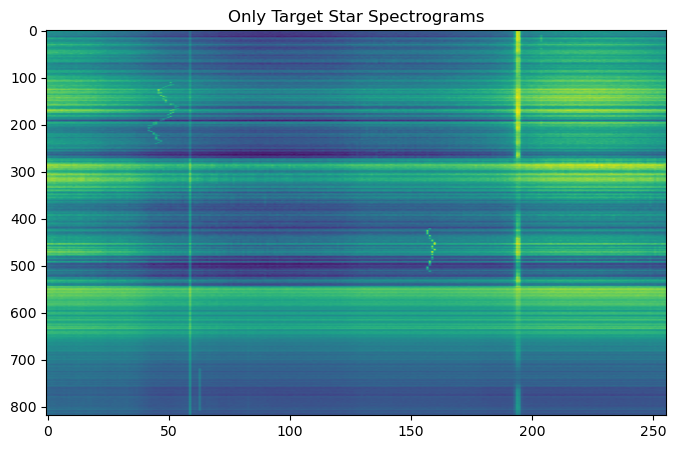

In [84]:
def merge_target_star_spectrograms_preprocess(npy_file):
    return np.vstack([npy_file[0], npy_file[2], npy_file[4]])

cadence_snippet = np.load(f'{CFG.base_folder_path}/positive.npy')
cadence_snippet = merge_target_star_spectrograms_preprocess(cadence_snippet)

print(f'My shape is: {cadence_snippet.shape}')
plot_merged_cadence_snippet(cadence_snippet, 'Only Target Star Spectrograms')

Then, we did a resize, trying to make the image even smaller:

My shape is: (409, 128)


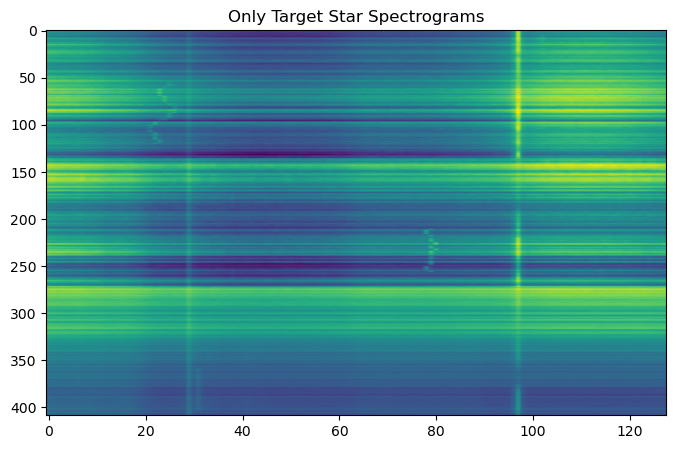

In [77]:
def resize_spectrograms_preprocess(cadence_snippet):
    new_shape = (cadence_snippet.shape[0] // 2, cadence_snippet.shape[1] // 2)
    return resize(cadence_snippet, new_shape)

resized_cadence_snippet = resize_spectrograms_preprocess(cadence_snippet)
print(f'My shape is: {resized_cadence_snippet.shape}')
plot_merged_cadence_snippet(resized_cadence_snippet, 'Only Target Star Spectrograms')

After that, we tried some more things that didnt worked for us - dimensionality reduction and feature extraction
- The first thing we did was **dimensionality reduction**, but it turned out that its distorting the image quality (although we tried 3 different ways: PCA, TSNE and UMAP)
- The second thing was **feature extraction**, which turned out that its not pretty helpful in reducing image size (although we tried 3 different ways: SIFT, HOG and LBP). it may be helpful for the model in other ways, by making it easier for him to find the meaningful spots in the image - but we chose to change to model to deep learning one so it wont be needed anyway. <br></br>

Having said that, we can combine all the new functions into a new preprocess pipeline function:

In [81]:
def improved_preprocessing_pipeline(data_set):
  processed_data_set = []

  for data_file_path in data_set['file_path']:
    data = (np.load(data_file_path))

    # Mask horizontal lines
    processed_data = fourier_transform_preprocess(data)

    # Merge star's spectrograms only into one image
    processed_data = merge_target_star_spectrograms_preprocess(processed_data)

    # Normalized the spectrograms values
    processed_data = normalize_spectrograms_preprocess(processed_data)
    
    # Resize the spectrogram shape
    processed_data = resize_spectrograms_preprocess(processed_data)
    
    processed_data_set.append(processed_data.flatten())

  return processed_data_set

Right now, we can pass it as a parameter to our `batched_preprocess_pipeline` and to run our new pipeline on the entire dataset, and then run the whole training process over our new process data:

In [ ]:
preprocessing_batched_pipeline(training_set, CFG.train_batch_size, improved_preprocessing_pipeline, 'train')
preprocessing_batched_pipeline(testing_set, CFG.train_batch_size, improved_preprocessing_pipeline, 'test')

run_learning_process(model, 'Logistic Reg')

Started training 0 fold at 0.007308049996693929 min
Finished training 0 fold at 44.767487064997354 min. 3 remaines
Started validation 0 fold at 44.76750200986862 min min
Finished validation 0 fold at 86.4893567999204 min. its score is 0.5684000000000002
Started training 1 fold at 86.49759704271952 min
Finished training 1 fold at 133.56840271552403 min. 2 remaines
Started validation 1 fold at 133.56841549475988 min
Finished validation 1 fold at 176.1964283108711 min. its score is 0.6690666666666668
Started training 2 fold at 176.20479395389557 min
Finished training 2 fold at 225.181547164917 min. 1 remaines
Started validation 2 fold at 225.181547210015 min
Finished validation 2 fold at 267.223605632782 min. its score is 0.7280000000000001
Started training 3 fold at 267.273607492447 min
Finished training 3 fold at 320.8873722553253 min. 0 remaines
Started validation 3 fold at 320.8883736133575 min
Finished validation 3 fold at 361.0460107326508 min. its score is 0.813000000000001
Finishe

As we can see in the results above, we managed to reduce the process running time from 9 to 6 hours. But, our **accuracy model problem** still needs to be solved.

In order to address the accuracy issue - we will move in the next section to **deep learning model**, who should help us to get better results.

----

# <a id='7'>7. Train A Deep Learning Model | 🤖</a>

Before we are starting to work on a deep learning model - let's start with understand the different between ML models to DL models, which are both subsets of AI, but they differ significantly in their complexity and capabilities. 

- **ML models**, involves training models on data using statistical techniques to enable machines to improve their performance over time without being explicitly programmed.
- **DL models**, employs neural networks with many layers (hence "deep") to model complex patterns in large amounts of data.
<br></br>
<table>
    <thead>
        <tr>
            <th> Aspect </th> 
            <th> ML models </th>
            <th> DL models </th>
        </tr>
     </thead>
    <tbody>
        <tr>
            <td>Complexity</td>
            <td>Involves simpler algorithms with manual feature extraction</td>
            <td>Uses complex neural networks with automatic feature extraction</td>
        </tr>
        <tr>
            <td>Data Dependency</td>
            <td>Effective with smaller datasets</td>
            <td>Requires large datasets</td>
        </tr>
        <tr>
            <td>Interpretability</td>
            <td>Models are more interpretable</td>
            <td>Models can be seen as "black boxes"</td>
        </tr>
        <tr>
            <td>Computational Requirements</td>
            <td>Less computationally demanding</td>
            <td>Requires substantial computational power</td>
        </tr>
    </tbody>
</table>
<br></br>
Now, after understanding the power of Deep Learning models - let's create one for our needs:

### <a id='7_1'>7.1 Model Building</a>


For our model building and for the rest of the code, we will mostly use `TensorFlow` and `Keras`
- **TensorFlow** is an open-source machine learning framework developed by Google. It is widely used for building and training machine learning models. it is allows the creation of both machine learning and deep learning models and optimized for performance on various hardware (like CPUs, GPUs, TPUs, etc)
- **Keras** is a high-level neural networks API, written in Python and capable of running on top of TensorFlow. It is designed to enable fast experimentation with deep learning models.

Now, in order to create our Keras model - we need to define our model's architecture first (the overall structure of our neural network - input, hidden and output layer). Our architecture is built from:

- **Input Layer** - specifies `(224, 224, 3)` shape for the input data, which corresponds to 224x224 pixel images with 3 color channels (RGB).
- **Hidden Layers** - the intermediate layers between the input and output layers where the actual computation takes place.
    - *Conv2D* - the building blocks of CNNs which used to extract features from input images. The `Conv2D` layer using set of learnable filters (also known as kernels) to produce feature maps. In our code, the layer has 3 filters with a kernel size of (3,3).
    - *EfficientNetB4* - a pre-trained convolutional neural network uses pre-trained weights from the ImageNet dataset, known for its efficiency and performance.
    - *GlobalAveragePooling2D* - used to reduce the spatial dimensionality of the image extracted features
- **Output Layer** - the output layer has a single neuron with sigmoid activation that produces a binary classification output (0 or 1)

In [16]:
def create_model():
  input_shape = (224,224, 3)

  return tf.keras.Sequential([
    layers.Input(shape=input_shape),
    layers.Conv2D(3, (3, 3), padding='same'),
    efficientnet.EfficientNetB4(weights='imagenet',include_top=False),
    layers.GlobalAveragePooling2D(),
    layers.Dense(1, activation='sigmoid')
  ])

# Main
model = create_model()
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 224, 224, 3)    │            84 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnet-b4 (Functional)    │ (None, 7, 7, 1792)     │    17,673,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1792)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │         1,793 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,675,693 (67.43 MB)

 Trainable params: 17,550,493 (66.95 MB)

 Non-trainable params: 125,200 (489.06 KB)

### <a id='7_2'>7.2 Preprocessing Pipeline</a>



Our preprocessing pipeline will be pretty identical to the one in section 6, but it will resize the spectrograms to a different shape:

Before preprocessing:
My shape is: (6, 273, 256)


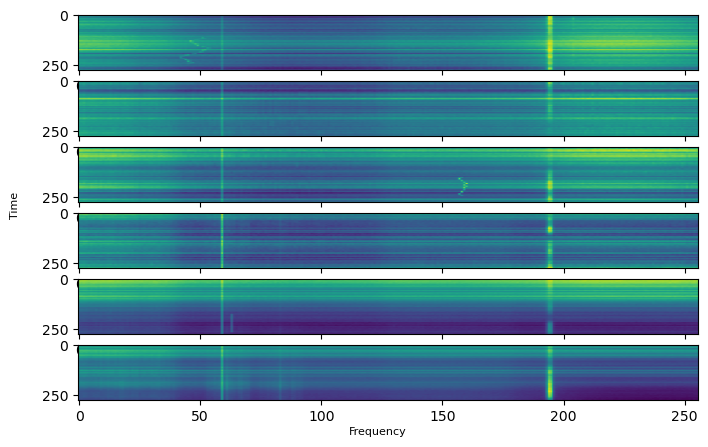

After preprocessing:
My shape is: (224, 224)


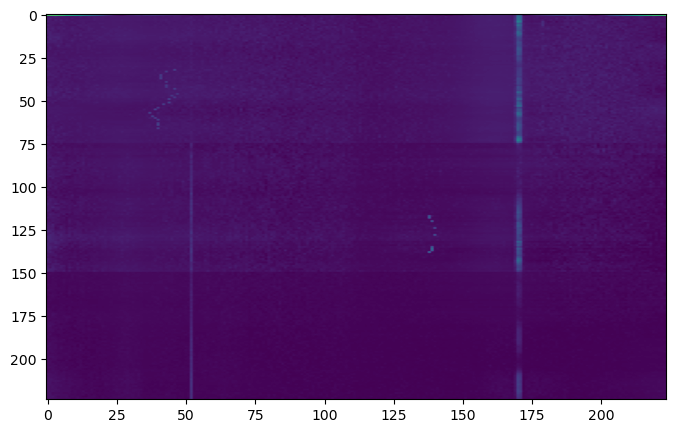

In [99]:
def deep_learning_preprocessing_pipeline(data_sample_path):
    data_sample = (np.load(data_sample_path))

    # Mask horizontal lines
    data_sample = fourier_transform_preprocess(data_sample)

    # Select channels 0,2,4 only
    data_sample = merge_target_star_spectrograms_preprocess(data_sample)
    
    # Normalized the spectrograms values
    data_sample = normalize_spectrograms_preprocess(np.abs(data_sample))
    
    # Resize the spectrogram's shape
    data_sample = cv2.resize(data_sample, dsize=(224, 224), interpolation=cv2.INTER_NEAREST)
    
    return data_sample

# Main
cadence_snippet_filepath = f'{CFG.base_folder_path}/positive.npy'
cadence_snippet = np.load(cadence_snippet_filepath)
print('Before preprocessing:')
print(f'My shape is: {cadence_snippet.shape}')
plot_cadence_snippet(cadence_snippet)

processed_cadence_snippet = deep_learning_preprocessing_pipeline(cadence_snippet_filepath)
print('After preprocessing:')
print(f'My shape is: {processed_cadence_snippet.shape}')
plot_merged_cadence_snippet(processed_cadence_snippet)

<div style="border: 2px solid; padding: 10px; background-color: #FFFACD; border-radius: 5px; color: #000; font-size:14px; line-height: 1.7em; display: flex; flex-direction: row;">
  <div style="width: 24px">📌</div> Our EfficientNetB4 model layer, was pre-trained mostly on 224x224 pixels image - so we resized our spectrograms as well
</div>

Instead of using our regular `preprocessing_batched_pipeline` function in order to run this pipeline on our entire data set and store it - 
apparently, using `TensorFlow` framework, let us use a great data storage format called `TFRecords`.

The **TFRecord** (`.tfrecord`/`.tfrec`) format is TensorFlow's custom data format which is used for storing a sequence of binary records. 
It takes up **less space on the storage disk**, and **takes less time to read and write from the disk**.
There are a number of advantages to using TFRecords: 
* More efficient storage
* Fast I/O
* Self-contained files
* TPUs require that you pass data to them in TFRecord format

Now, let's create our `serialize_tfrecord`, `deserialize_tfrecord` functions:

In [ ]:
# ------------------------------------#
# Serialize
# ------------------------------------#
def feature_to_bytes_list(value):
    # BytesList won't unpack a string from an EagerTensor.
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy()

    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def feature_to_int64_list(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def serialize_tfrecord(data, label):
    features = {
        'data': feature_to_bytes_list(value=data),
        'label': feature_to_int64_list(value=label)
    }

    tf_protocol_buffer = tf.train.Example(features=tf.train.Features(feature=features))

    return tf_protocol_buffer.SerializeToString()

# ------------------------------------#
# Deserialize
# ------------------------------------#
def parse_record_data(data):
    data = tf.image.decode_png(data, channels=3)
    # Convert image to floats in [0, 1] range
    data = tf.cast(data, tf.float16) / 255.0
    return tf.reshape(data, [224,224,3])

def parse_record_label(label):
    label = tf.cast(label, tf.float16)            
    return tf.reshape(label, [1])    

def deserialize_tfrecord(filepath):
    features = {
        'data': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([], tf.int64)
    }

    record = tf.io.parse_single_example(filepath, features)

    return parse_record_data(record['data']), parse_record_label(record['label'])

Now we can add `tfrecords_preprocessing` function, that run the preprocessing pipeline over a dataset and store it as `tfrec.`:

In [14]:
def tfrecords_preprocessing(data, labels, filename):
    with tf.io.TFRecordWriter(filename) as writer:
        for data_sample, label in zip(data, labels):
            processed_data = deep_learning_preprocessing_pipeline(data_sample)[...,::-1]
            data_record = serialize_tfrecord(cv2.imencode('.png', processed_data)[1].tobytes(), label)
            writer.write(data_record)

def training_set_preprocessing_pipeline():
    for fold_index in range(CFG.k_fold):
        fold = training_set[training_set['fold'] == fold_index]

        tfrecords_preprocessing(fold['file_path'], fold['target'], f'train_byte_{fold_index+1}.tfrecord')

def testing_set_preprocessing_pipeline():
    tfrecords_preprocessing(testing_set['file_path'], testing_set['target'], 'test_byte.tfrecord')

training_set_preprocessing_pipeline()
testing_set_preprocessing_pipeline()

### <a id='7_3'>7.3 Training Function</a>


In [68]:
buffer_size = 20

def load_dataset(files_path):
    options = tf.data.Options()
    # This definition is causing optimal performance by reading from multiple files at once disregarding data order.
    options.experimental_deterministic = False

    dataset = tf.data.TFRecordDataset(files_path, num_parallel_reads=tf.data.experimental.AUTOTUNE)
    dataset = dataset.with_options(options) 
    return dataset.map(deserialize_tfrecord)

def get_dataset(files_path, batch_size, shuffle=False):
    dataset = load_dataset(files_path)
    dataset = dataset.repeat(1)

    if shuffle:
        dataset = dataset.shuffle(buffer_size, seed=CFG.seed)

    dataset = dataset.batch(batch_size)
    # Prefetch next batch while training (autotune prefetch buffer size)
    return dataset.prefetch(tf.data.experimental.AUTOTUNE) 

In [69]:
verbosity_mode = 2

def training():
   tfrecord_files = [f'train_byte_{i+1}.tfrecord' for i in range(CFG.k_fold)]

   for fold_index in range(CFG.k_fold):
      train_tfrecord_files = [files for i, files in enumerate(tfrecord_files) if i != fold_index]
      validation_tfrecord_files = [tfrecord_files[fold_index]]

      train_dataset = get_dataset(train_tfrecord_files, batch_size=CFG.train_batch_size, shuffle=True)
      validation_dataset = get_dataset(validation_tfrecord_files, batch_size=CFG.train_batch_size, shuffle=True)

      model = create_model()
      model.compile(loss='binary_crossentropy', metrics=['accuracy'])

      model.fit(
         train_dataset, 
         epochs=CFG.epochs, 
         validation_data=validation_dataset,
         verbose=verbosity_mode, 
         callbacks=[TqdmCallback(verbose=verbosity_mode)]
      )

      try:
        loss, accuracy = model.evaluate(validation_dataset)
        print(f'Validation Loss: {loss}, Validation Accuracy: {accuracy}')
      except Exception as e:
        print('Error during evaluation:', str(e))



# Main
training()

0epoch [00:00, ?epoch/s]

0.00batch [00:00, ?batch/s]